<a href="https://colab.research.google.com/github/derykroot/clthinsections/blob/main/CLThinSections.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Aprendizado continuo na classificação de microfosseis em laminas delgadas**

Nesse experimento foi feito testes de estratégias de aprendizado continuo divididos em 2 etapas por teste, a primeira etapa consiste no treinamento para classificação de 2 classes, a segunda etapa é adicionado mais uma classe e novas amostras das classes anteriores.

A primeira classe é composta por amostras de Ooides, um tipo de grão não esqueletal, a segunda é composta por amostras de miliolideos, um tipo de foraminifero, a terceira que será adicionada no segundo treino são amostras de Ostracodes.

In [2]:
!pip install avalanche-lib

import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 582 kB 4.8 MB/s 
     |████████████████████████████████| 529 kB 74.1 MB/s 
     |████████████████████████████████| 1.9 MB 68.6 MB/s 
     |████████████████████████████████| 427 kB 78.1 MB/s 
     |████████████████████████████████| 532 kB 90.4 MB/s 
     |████████████████████████████████| 168 kB 78.1 MB/s 
     |████████████████████████████████| 182 kB 80.2 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
     |████████████████████████████████| 166 kB 85.9 MB/s 
     |████████████████████████████████| 166 kB 96.6 MB/s 
     |████████████████████████████████| 162 kB 87.5 MB/s 
     |████████████████████████████████| 162 kB 89.7 MB/s 
     |████████████████████████████████| 158 kB 91.1 MB/s 
     |████████████████████████████████| 157 kB 91.0 MB/s 
     |████████████████████████████████| 157 kB 94.3 MB/s 
     |████████████████████████████

In [ ]:
!gdown 1qG4ujSQoa8CB1D-IqF-x-SrcvVX2ditC
!tar xvf dataset.tar

# Funções de apoio

In [4]:
def showimg(img):
  plt.imshow(img)
  plt.show()

def showimgs(imgs):
  fig, ax = plt.subplots(1, len(imgs), figsize=(15,15))
  #fig, ax = plt.subplots(1, len(imgs))
  for i in range(len(imgs)):
    ax[i].imshow(imgs[i], cmap='gray')
    ax[i].axis('off')
  plt.show()

def showparts(imgs, nparts = 4):
    ishow = []
    for i in range(len(imgs)):
        ishow.append(imgs[i])
        if ((i+1) % nparts) == 0:
            showimgs(ishow)
            ishow = []

def showmetrics(histloss, histacc):
  fig, ax = plt.subplots(1, 2, figsize=(12, 5)) 
  ax[0].plot(histloss, 'go-', label='Loss')
  ax[0].legend()
  ax[1].plot(histacc, 'o-', label='Acc')
  ax[1].legend()

  plt.show()

# Dataset

Para os treinos foi constituido 3 datasets: o primeiro é composto por 62 amostras de imagens de Ooides, e 55 de Miliolideos, mais 20 de cada para validação do treino totalizando em 157 imagens; o segundo dataset é composto por 89 smostras de ostracodes com mais 25 para validação, foi adicionado tambem 30 imagens de Ooides e mais 30 de Miliolideos com mais 5 de cada para validação totalizando em 184 imagens. O terceiro é formado pela soma de todas a imagens dos 2 datasets anteriores.

O primeiro dataset contêm apenas 2 classes. O segundo contêm 3 classes, com imagens da classe adicional e com imagens novas das 2 classes do primeiro dataset. O terceiro é a soma do primeiro e segundo datasets com o propósito de testar a acurácia do aprendizado incremental.

Cada dataset é dividido em 2 datasets, um com amostras para treino da rede neural e outro com amostras para validação do treino totalizando em 6 datasets, 3 para treinos e 3 para validação

In [5]:
transform = transforms.Compose(
    [
        transforms.Resize((224, 224), transforms.InterpolationMode.BICUBIC),
        transforms.Grayscale(),
        transforms.ToTensor()
    ]
)

tset = datasets.ImageFolder('./ds/train',  transform=transform)
vset = datasets.ImageFolder('./ds/val', transform=transform) 

tsetnew = datasets.ImageFolder('./dsn/train',  transform=transform)
vsetnew = datasets.ImageFolder('./dsn/val', transform=transform)

tsetall = datasets.ImageFolder('./dsa/train',  transform=transform)
vsetall = datasets.ImageFolder('./dsa/val', transform=transform) 


tloader = torch.utils.data.DataLoader(tset, batch_size=16, shuffle=True)
vloader = torch.utils.data.DataLoader(vset, batch_size=1, shuffle=False)

tloadernew = torch.utils.data.DataLoader(tsetnew, batch_size=16, shuffle=True)
vloadernew = torch.utils.data.DataLoader(vsetnew, batch_size=1, shuffle=False)

tloaderall = torch.utils.data.DataLoader(tsetall, batch_size=16, shuffle=True)
vloaderall = torch.utils.data.DataLoader(vsetall, batch_size=1, shuffle=False)


Ooides, Miliolideos, Ostracodes


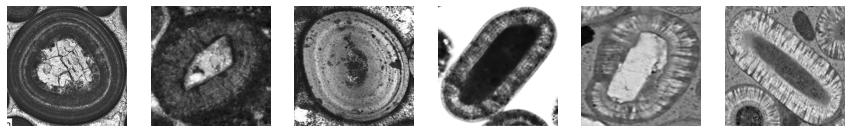

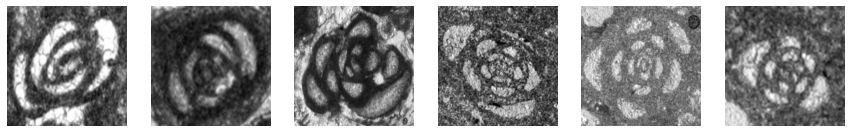

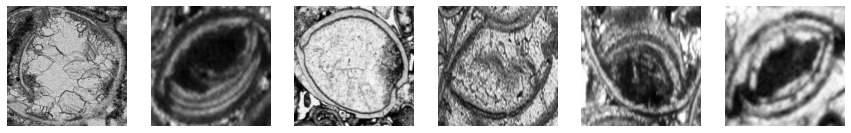

In [6]:

print("Ooides, Miliolideos, Ostracodes")
imgs = [tsetall[i][0][0] for i in [0,5,10,15,25,30]]
imgs.extend([tsetall[i][0][0] for i in [105,111,112,113,114,115]])
imgs.extend([tsetall[i][0][0] for i in [190,195,200,205,210,225]])
showparts(imgs, 6)


Funções para validar a acurácia da rede treinada 

In [7]:
from itertools import groupby

def pred(model, img):
    with torch.no_grad(): # desativar o autograd para acelerar a validação. Grafos computacionais dinâmicos tem um custo alto de processamento
        logps = model(img) # output do modelo em escala logaritmica

    ps = torch.exp(logps) # converte output para escala normal(lembrando que é um tensor)
    probabs = list(ps.cpu().numpy()[0]) # converte o tensor em um número
    return probabs.index(max(probabs)), probabs # Retorna o mais provavel junto com todas as probabilidades

def validacao(modelo, valloader, device, nome="", showfails = False, showgp = False):
    ctdcorretas, ctdtodas = 0, 0
    w, h = valloader.dataset.transform.transforms[0].size

    classes = dict()
    for i, v in groupby(valloader.dataset.targets): classes[str(i)] = 0

    for imagens, rotulos in valloader:
      for i in range(len(rotulos)):
        img = imagens[i].view(1, 1, w, h)
                
        r_pred, probs = pred(modelo, img.to(device)) # converte o tensor em um número, no caso, o número que o modelo previu como correto 
        r_certo = rotulos.numpy()[i] 
        if(r_certo == r_pred): # compara a previsão com o valor correto
          ctdcorretas += 1
          classes[str(r_pred)] +=1
        else:
          if showfails:
            showimg(img[0][0]); print("res: ", r_pred +1); print(probs[:3])
        ctdtodas += 1
        

    print(nome + "Imagens testadas =", ctdtodas,". Precisão = {}%".format(ctdcorretas*100/ctdtodas)) 
    if showgp:
      for c in classes:
        totgrupo = valloader.dataset.targets.count(int(c))
        print("Grupo", int(c)+1,", Acertou: ", classes[c],". Precisão = {}%".format(classes[c]*100/totgrupo))

    return ctdcorretas*100/ctdtodas

*Rede VGG19*

Escolhemos a rede com arquitetura VGG19, uma rede Convolucional que apresenta bom desempenho

In [81]:
import gc

from torchvision import models as tvmodels 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # modelo rodará na GPU se possível

def newnet():
    torch.cuda.empty_cache()
    gc.collect()
    torch.cuda.empty_cache()

    net = tvmodels.vgg19(weights=tvmodels.VGG19_Weights.DEFAULT)
    net.features.add_module("0", nn.Conv2d(1, 64, kernel_size=(3,3), padding=(1, 1)))
    net.classifier.add_module("6", nn.Linear(4096, 3))
    net.classifier.append(nn.LogSoftmax(1))
    nn.init.xavier_normal_(net.classifier[6].weight)
    return net

from avalanche.evaluation.metrics import forgetting_metrics, accuracy_metrics, loss_metrics
from avalanche.training.plugins import EvaluationPlugin
from avalanche.logging import InteractiveLogger

def neweval():
    loggers = []
    loggers.append(InteractiveLogger())
    return EvaluationPlugin(accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True), loss_metrics(minibatch=True, epoch=True, experience=True, stream=True),
                    forgetting_metrics(experience=True, stream=True),
                    loggers=loggers) #, benchmark=scn
    

In [56]:
net.classifier[6].weight.shape

torch.Size([3, 4096])

Otimizadores

In [9]:
def getoptmSGD(modelo, _lr=0.001):
    return optim.SGD(modelo.parameters(), lr=_lr, momentum=0.9) # define a política de atualização dos pesos e da bias

def getoptmAdamW(modelo, _lr=0.0001):
    return torch.optim.AdamW(modelo.parameters(), lr=_lr)

# Treinamento do dataset com todas as amostras

O primeiro treinamento é feito com o dataset que contêm todas as amostras, esse treinamente serve como base para comparar outros treinamentos

In [ ]:
class histloss():
    def __init__(self) -> None:
        self.histloss =[]

hloss = histloss()

def treino(modelo, trainloader, device, otimizador, EPOCHS = 10, intervalomostra = 1):
    inicio = time() # timer para sabermos quanto tempo levou o treino
    
    criterio = nn.CrossEntropyLoss() 

    modelo.train() # ativando o modo de treinamento do modelo

    for epoch in range(EPOCHS):
        perda_acumulada = 0 # inicialização da perda acumulada da epoch em questão
        
        for imagens, rotulos in trainloader:            
            otimizador.zero_grad() 
            output = modelo(imagens.to(device))
            perda_instantanea = criterio(output, rotulos.to(device)) 
            perda_instantanea.backward() 
            otimizador.step()
            perda_acumulada += perda_instantanea.item() 
        
        else:
            if (epoch % intervalomostra) == 0:
                print("Epoch {} - Perda resultante: {}".format(epoch+1, perda_acumulada/len(trainloader)))
            hloss.histloss.append(perda_acumulada/len(trainloader))
    print("\nTempo de treino (em minutos) =",(time()-inicio)/60)

net = newnet()
net.to(device).classifier

treino(net, tloaderall, device, getoptmSGD(net, _lr=0.0001), 150)

In [96]:
resall = validacao(net, vloaderall, device, nome="\nTodas as Amostras: \n", showgp=True)


Todas as Amostras: 
Imagens testadas = 75 . Precisão = 100.0%
Grupo 1 , Acertou:  25 . Precisão = 100.0%
Grupo 2 , Acertou:  25 . Precisão = 100.0%
Grupo 3 , Acertou:  25 . Precisão = 100.0%


[3.5261158e-07, 2.6480594e-08, 0.99999964]

Resultado da predição:  3-Ostracodes


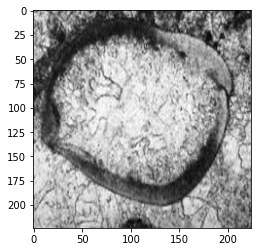

In [97]:
from random import random

img, idx = vsetall[int(random() *75)]
plt.imshow(img[0], cmap="gray")
img = img.view(1, 1, 224, 224) # Formato (batch_size, número de canais, altura largura)
rpred, probs = pred(net, img.to(device))
print(probs[:3]) 

print("\nResultado da predição: ",(["1-Ooides","2-Miliolideos","3-Ostracodes"])[rpred])

# Treinamento Incremental sem CL

In [ ]:
net = newnet()
net.to(device).classifier

treino(net, tloader, device, getoptmSGD(net, _lr=0.0001), 100)

In [ ]:
treino(net, tloadernew, device, getoptmSGD(net, _lr=0.0001), 80)

In [94]:
resscl = validacao(net, vloaderall, device, nome="\nTodas as Amostras: \n", showgp=True)


Todas as Amostras: 
Imagens testadas = 75 . Precisão = 93.33333333333333%
Grupo 1 , Acertou:  25 . Precisão = 100.0%
Grupo 2 , Acertou:  20 . Precisão = 80.0%
Grupo 3 , Acertou:  25 . Precisão = 100.0%


# Treinamento Continuo/Incremental com Framework Avalanche

*Testes de estratégias de aprendizado continuo/incremental*

Para testar estratégias de aprendizado continuo nesse experimento foi usado o framework Avalanche que implementa os algoritmos legados de aprendizado continuo. Nesse estudo foi testado 3 estratégias para o treinamento, EWC (Elastic Weight Consolidation), GEM (Gradient Episodic Memory) e LWF (Learning without Forgetting) 

Para testar foi usado 2 cenários, o primeiro com amostras de 2 classes (Ooides e Miliolideos). O segundo foi cenário é utilizado o dataset que contêm apenas novas imagens de Ooides e Miliolideos e com imagens de mais uma classe adicional de Ostracodes.

O objetivo desses testes é realizar 2 treinos, o primeiro com imagens de Ooides e Miliolideos e o segundo com o incremento de mais uma classe composta por imagens de ostracodes e com apenas imagens inéditas de Ooides e Miliolideos. Depois do segundo treino testamos a acurácia da rede sobre as amostras de validação do primeiro treino para medir o esquecimento catastrófico em relação as amostras do primeiro treinamento.

In [31]:
from avalanche.benchmarks.utils import AvalancheDataset
from avalanche.benchmarks.generators import nc_benchmark, ni_benchmark, dataset_benchmark


atset = AvalancheDataset(tset, task_labels = 0)
avset = AvalancheDataset(vset, task_labels = 0)
atsetnew = AvalancheDataset(tsetnew, task_labels = 0)
avsetnew = AvalancheDataset(vsetnew, task_labels = 0)

scn = dataset_benchmark([atset], [avset])
scnnew = dataset_benchmark([atsetnew], [avsetnew])

# EWC

In [ ]:
from avalanche.training import EWC, GEM, LwF

optimizer = getoptmSGD(net, _lr = 0.0001) #  torch.optim.Adam(net.parameters(),lr=0.0001) # 
crit = nn.CrossEntropyLoss()
eval_plugin = neweval()

net = newnet()
cl_strategy = EWC(net, optimizer, crit, 1000000, train_mb_size=16,eval_mb_size=1,
                  train_epochs=100, evaluator=eval_plugin, device=device)


for train_exp in scn.train_stream:
    cl_strategy.train(train_exp)

Faremos o treinamento do primeiro conjunto, chamaremos o primeiro conjunto de Conjunto A e o segundo conjunto treinado posteriormente como conjunto B

In [ ]:
validacao(net, vloader, device, nome="\nAmostras do primeiro dataset: \n", showfails=False)
validacao(net, vloaderall, device, showfails=False, nome="\nTodas as Amostras: \n", showgp=True)

In [ ]:
cl_strategy = EWC(net, optimizer, crit, 1000000, train_mb_size=16,eval_mb_size=1,
                  train_epochs=80, evaluator=eval_plugin, device=device)

for train_exp in scnnew.train_stream:
    cl_strategy.train(train_exp)

In [ ]:
validacao(net, vloader, device, nome="\nAmostras do dataset do primeiro treino: \n", showfails=False)
resewc = validacao(net, vloaderall, device, nome="\nTodas as Amostras: \n", showgp=True)

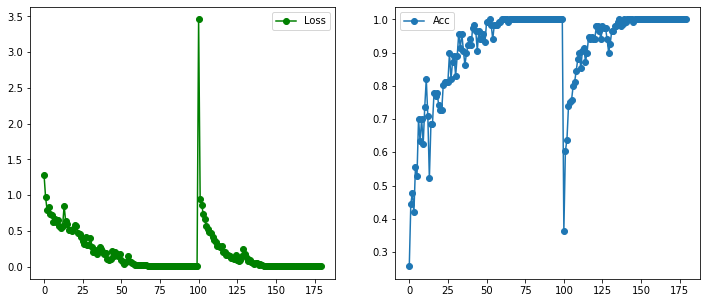

In [88]:
showmetrics(eval_plugin.all_metric_results['Loss_Epoch/train_phase/train_stream/Task000'][1],
            eval_plugin.all_metric_results['Top1_Acc_Epoch/train_phase/train_stream/Task000'][1])

# LWF

In [98]:
from avalanche.training import LwF

net = newnet()

optimizer = getoptmSGD(net, _lr = 0.0001) #  torch.optim.Adam(net.parameters(),lr=0.0001) # 
crit = nn.CrossEntropyLoss()
eval_plugin = neweval()

cl_strategy = LwF(net, optimizer, crit, [0, 0.5, 1.333, 2.25, 3.2], 1, train_mb_size=16,eval_mb_size=1,
                   train_epochs=100, evaluator=eval_plugin, device=device)

for train_exp in scn.train_stream:
    cl_strategy.train(train_exp)

-- >> Start of training phase << --
100%|██████████| 8/8 [00:00<00:00,  9.28it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.1774
	Loss_MB/train_phase/train_stream/Task000 = 0.9857
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.3932
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.6000
100%|██████████| 8/8 [00:00<00:00,  9.36it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.8825
	Loss_MB/train_phase/train_stream/Task000 = 0.7607
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.5470
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.4000
100%|██████████| 8/8 [00:00<00:00,  9.63it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.8082
	Loss_MB/train_phase/train_stream/Task000 = 0.6945
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.5470
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.6000
100%|██████████| 8/8 [00:00<00:00,  9.26it/s]
Epoch 3 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.6976
	Loss_MB/tra

In [99]:
cl_strategy = LwF(net, optimizer, crit, [0, 0.5, 1.333, 2.25, 3.2], 1, train_mb_size=16,eval_mb_size=1,
                   train_epochs=80, evaluator=eval_plugin, device=device)

for train_exp in scnnew.train_stream:
    cl_strategy.train(train_exp)

-- >> Start of training phase << --
100%|██████████| 10/10 [00:01<00:00,  9.18it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 3.1616
	Loss_MB/train_phase/train_stream/Task000 = 1.1294
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.3087
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.2000
100%|██████████| 10/10 [00:01<00:00,  9.04it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.9950
	Loss_MB/train_phase/train_stream/Task000 = 1.2102
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.5436
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.6000
100%|██████████| 10/10 [00:01<00:00,  8.94it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.8945
	Loss_MB/train_phase/train_stream/Task000 = 0.5624
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.6040
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.8000
100%|██████████| 10/10 [00:01<00:00,  9.13it/s]
Epoch 3 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.8486
	Los

In [100]:
validacao(net, vloader, device)
reslwf = validacao(net, vloaderall, device, nome="\nTodas as Amostras: \n", showgp=True)

Imagens testadas = 40 . Precisão = 95.0%

Todas as Amostras: 
Imagens testadas = 75 . Precisão = 94.66666666666667%
Grupo 1 , Acertou:  25 . Precisão = 100.0%
Grupo 2 , Acertou:  21 . Precisão = 84.0%
Grupo 3 , Acertou:  25 . Precisão = 100.0%


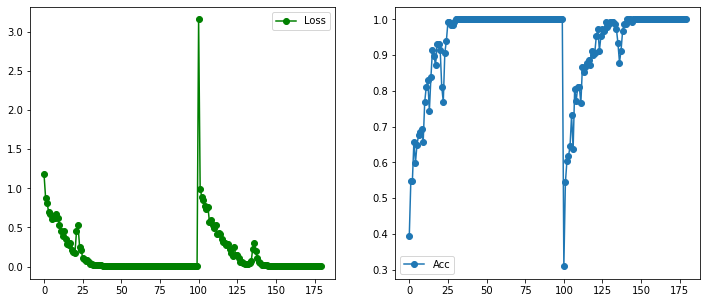

In [101]:
showmetrics(eval_plugin.all_metric_results['Loss_Epoch/train_phase/train_stream/Task000'][1],
            eval_plugin.all_metric_results['Top1_Acc_Epoch/train_phase/train_stream/Task000'][1])

# GEM

In [102]:
net = newnet()

optimizer = getoptmSGD(net, _lr = 0.0001) #  torch.optim.Adam(net.parameters(),lr=0.0001) # 
crit = nn.CrossEntropyLoss()
eval_plugin = neweval()

cl_strategy = GEM(net, optimizer, crit, 256, train_mb_size=16,eval_mb_size=1,
                  train_epochs=100, evaluator=eval_plugin, device=device)

for train_exp in scn.train_stream:
    cl_strategy.train(train_exp)

-- >> Start of training phase << --
100%|██████████| 8/8 [00:00<00:00,  9.11it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.2227
	Loss_MB/train_phase/train_stream/Task000 = 0.5861
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.2991
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.8000
100%|██████████| 8/8 [00:00<00:00,  9.40it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.8070
	Loss_MB/train_phase/train_stream/Task000 = 0.4376
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.6325
	Top1_Acc_MB/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 8/8 [00:00<00:00,  9.54it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.7083
	Loss_MB/train_phase/train_stream/Task000 = 0.5857
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.6154
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.8000
100%|██████████| 8/8 [00:00<00:00,  9.31it/s]
Epoch 3 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.5888
	Loss_MB/tra

In [103]:
cl_strategy = GEM(net, optimizer, crit, 256, train_mb_size=16,eval_mb_size=1,
                  train_epochs=80, evaluator=eval_plugin, device=device)

for train_exp in scnnew.train_stream:
    cl_strategy.train(train_exp)

-- >> Start of training phase << --
100%|██████████| 10/10 [00:01<00:00,  9.00it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 2.5255
	Loss_MB/train_phase/train_stream/Task000 = 0.9440
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.3356
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.6000
100%|██████████| 10/10 [00:01<00:00,  8.92it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.9720
	Loss_MB/train_phase/train_stream/Task000 = 1.8664
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.5772
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.2000
100%|██████████| 10/10 [00:01<00:00,  8.49it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.8668
	Loss_MB/train_phase/train_stream/Task000 = 1.2731
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.5973
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.2000
100%|██████████| 10/10 [00:01<00:00,  8.64it/s]
Epoch 3 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.8043
	Los

In [107]:
validacao(net, vloader, device)
resgem = validacao(net, vloaderall, device, nome="\nTodas as Amostras: \n", showgp=True)

Imagens testadas = 40 . Precisão = 92.5%

Todas as Amostras: 
Imagens testadas = 75 . Precisão = 97.33333333333333%
Grupo 1 , Acertou:  24 . Precisão = 96.0%
Grupo 2 , Acertou:  24 . Precisão = 96.0%
Grupo 3 , Acertou:  25 . Precisão = 100.0%


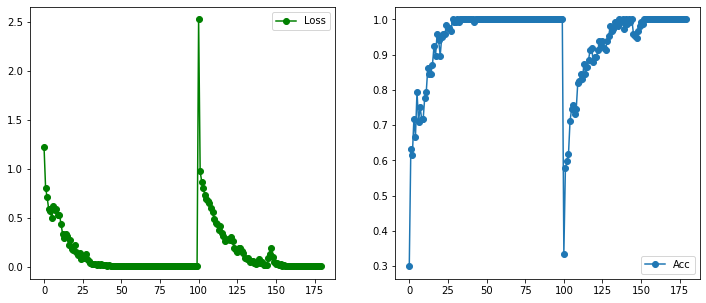

In [108]:
showmetrics(eval_plugin.all_metric_results['Loss_Epoch/train_phase/train_stream/Task000'][1],
            eval_plugin.all_metric_results['Top1_Acc_Epoch/train_phase/train_stream/Task000'][1])

In [109]:
def byres(r):
    return r[1]

resultados = [["Acurácia SemCL", resscl]]
resultados += [["Acurácia EWC", resewc]]
resultados += [["Acurácia LwF", reslwf]]
resultados += [["Acurácia GEM", resgem]]

print("Resultados da acurácia depois do segundo treino sobre as amostras do primeiro treino, ordenados do pior para o melhor:\n")
resultados.sort(key=byres)
for res in resultados:
    print(res[0], ":", res[1])

print("\nAcurácia do treinamento de todas as amostras: ", resall)

Resultados da acurácia depois do segundo treino sobre as amostras do primeiro treino, ordenados do pior para o melhor:

Acurácia SemCL : 93.33333333333333
Acurácia LwF : 94.66666666666667
Acurácia GEM : 97.33333333333333
Acurácia EWC : 98.66666666666667

Acurácia do treinamento de todas as amostras:  100.0
